#Решение


## Оглавление
- [Загрузка данных](#импорты-и-загрузка-данных)
- [Исследовательский анализ данных (EDA)](#исследовательский-анализ-данных-eda)
- [Предобработка данных](#предобработка-данных)
- [Построение моделей](#построение-моделей)
- [Выводы и рекомендации](#выводы-и-рекомендации)


##Загрузка данных
Здесь мы используем заранее подготовленный .csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# Подключение Google Drive
drive.mount('/content/drive')
load_path = '/content/drive/MyDrive/Colab Notebooks/students_data.csv'

# Загрузка данных
df_students = pd.read_csv(load_path, delimiter=',', header='infer').dropna(axis=0, how='any')
df_students['Pass'] = df_students['Grade'] >= 60

def show_distribution(var_data, column_name, enhanced=False):
    """
    Отображение распределения данных с опциональным улучшенным отображением.
    Параметры:
    - var_data: pd.Series — данные для анализа.
    - column_name: str — название столбца.
    - enhanced: bool — улучшенное отображение с выбросами.
    """
    # Статистика
    min_val, max_val = var_data.min(), var_data.max()
    mean_val, median_val = var_data.mean(), var_data.median()
    mode_val = var_data.mode()[0]

    # Выбросы для улучшенного режима
    if enhanced:
        q1, q3 = var_data.quantile(0.25), var_data.quantile(0.75)
        iqr = q3 - q1
        lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        outliers = var_data[(var_data < lower_bound) | (var_data > upper_bound)]
    else:
        outliers = []

    # Построение графиков
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})
    fig.suptitle(f'Распределение данных: {column_name}', fontsize=16)

    # Гистограмма
    ax[0].hist(var_data, bins=10, color=plt.cm.tab20b_r(0.4), edgecolor='black')
    ax[0].axvline(min_val, color='red', linestyle='dashed', linewidth=1.5, label='Min')
    ax[0].axvline(max_val, color='red', linestyle='dashed', linewidth=1.5, label='Max')
    ax[0].axvline(mean_val, color='black', linestyle='dashed', linewidth=1.5, label='Mean')
    ax[0].axvline(median_val, color='blue', linestyle='dashed', linewidth=1.5, label='Median')
    ax[0].axvline(mode_val, color='pink', linestyle='dashed', linewidth=1.5, label='Mode')
    ax[0].legend()
    ax[0].set_title('Гистограмма')
    ax[0].set_xlabel(column_name)
    ax[0].set_ylabel('Количество')

    # Boxplot
    ax[1].boxplot(var_data, vert=False, patch_artist=True, boxprops=dict(facecolor=plt.cm.tab20b_r(0.6)))
    ax[1].set_title('Boxplot')
    ax[1].set_xlabel(column_name)
    if enhanced:
        for outlier in outliers:
            ax[1].text(outlier, 1, f'{outlier:.2f}', color='orange', fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print(f'Минимум: {min_val:.2f},\nМаксимум: {max_val:.2f},\nСреднее: {mean_val:.2f},\nМедиана: {median_val:.2f},\nМода: {mode_val:.2f}')

def plot_bar_and_pie(data, grade_column, pass_column):
    """
    Построение столбчатой диаграммы и круговой диаграммы.

    Параметры:
    - data: DataFrame — таблица данных Pandas.
    - grade_column: str — столбец с оценками.
    - pass_column: str — столбец с результатами сдачи.
    """
    pass_counts = data[pass_column].value_counts()
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Bar
    colors = plt.cm.tab20b_r(np.linspace(0, 1, len(data)))
    bars = ax[0].bar(data['Name'], data[grade_column], color=colors)
    for bar, grade in zip(bars, data[grade_column]):
        ax[0].text(bar.get_x() + bar.get_width()/2, grade, str(round(grade)), ha='center')
    ax[0].set_title('Оценки студентов')
    ax[0].set_xlabel('Имя')
    ax[0].set_ylabel('Оценка')
    ax[0].tick_params(axis='x', rotation=90)

    # Pie
    ax[1].pie(pass_counts, labels=pass_counts.index, autopct='%1.1f%%',
              colors=plt.cm.tab20b_r(np.linspace(0, 1, len(pass_counts))))
    ax[1].set_title('Сдал/Не сдал')

    plt.tight_layout()
    plt.show()

def normalize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Нормализует числовые данные в DataFrame с помощью MinMaxScaler.

    Параметры:
    df (pd.DataFrame): Входной DataFrame, содержащий любые данные.

    Возвращает:
    pd.DataFrame: DataFrame с нормализованными числовыми столбцами.

    Описание процесса:
    - Создается копия DataFrame для сохранения оригинальных данных.
    - Определяются числовые столбцы с помощью `select_dtypes`.
    - Применяется MinMaxScaler, который масштабирует данные в диапазон [0, 1].
    - Остальные столбцы (например, текстовые) остаются без изменений.
    """
    df_copy = df.copy()  # Создание копии данных
    numeric_columns = df_copy.select_dtypes(include=['number']).columns
    scaler = MinMaxScaler()
    df_copy[numeric_columns] = scaler.fit_transform(df_copy[numeric_columns])
    return df_copy

def linear_regression_with_target(df: pd.DataFrame, target_column: str) -> (pd.DataFrame, float, float, float, float, float):
    """
    Выполняет линейную регрессию для числовых данных в DataFrame.

    Параметры:
    df (pd.DataFrame): Входной DataFrame с данными.
    target_column (str): Название столбца, который является целевой переменной (таргет).

    Возвращает:
    pd.DataFrame: Модернизированный DataFrame с добавленными столбцами 'fx' и 'error'.
    m (float): Угловой коэффициент регрессии.
    b (float): Пересечение с осью Y.
    r (float): Коэффициент корреляции.
    p (float): p-значение.
    se (float): Стандартная ошибка коэффициентов.
    """
    # Создаем копию исходного DataFrame
    df_copy = df.copy()

    # Выбираем только числовые столбцы
    numeric_columns = df_copy.select_dtypes(include=['number']).columns

    # Убираем целевой столбец из числовых столбцов
    numeric_columns = numeric_columns.drop(target_column)

    # Применяем линейную регрессию для числовых данных
    # Используем первый числовой столбец как независимую переменную
    x = df_copy[numeric_columns[0]]  # Первая числовая переменная
    y = df_copy[target_column]        # Целевая переменная

    # Выполняем линейную регрессию
    m, b, r, p, se = stats.linregress(x, y)

    # Создаем новый столбец 'fx' с предсказанными значениями
    df_copy['fx'] = (m * x) + b

    # Добавляем столбец 'error' с ошибками предсказаний
    df_copy['error'] = df_copy['fx'] - df_copy[target_column]

    # Возвращаем модернизированный DataFrame и коэффициенты
    return df_copy, m, b, r, p, se



Mounted at /content/drive


##Исследовательский анализ данных (EDA)
Смотрим во все глазищи

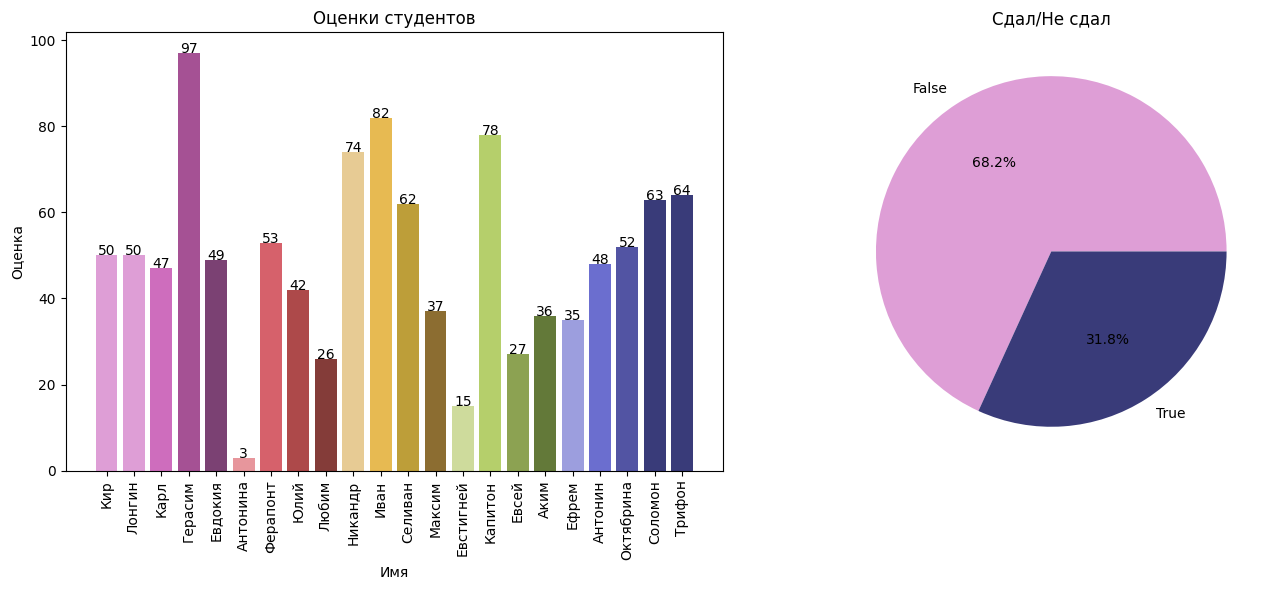

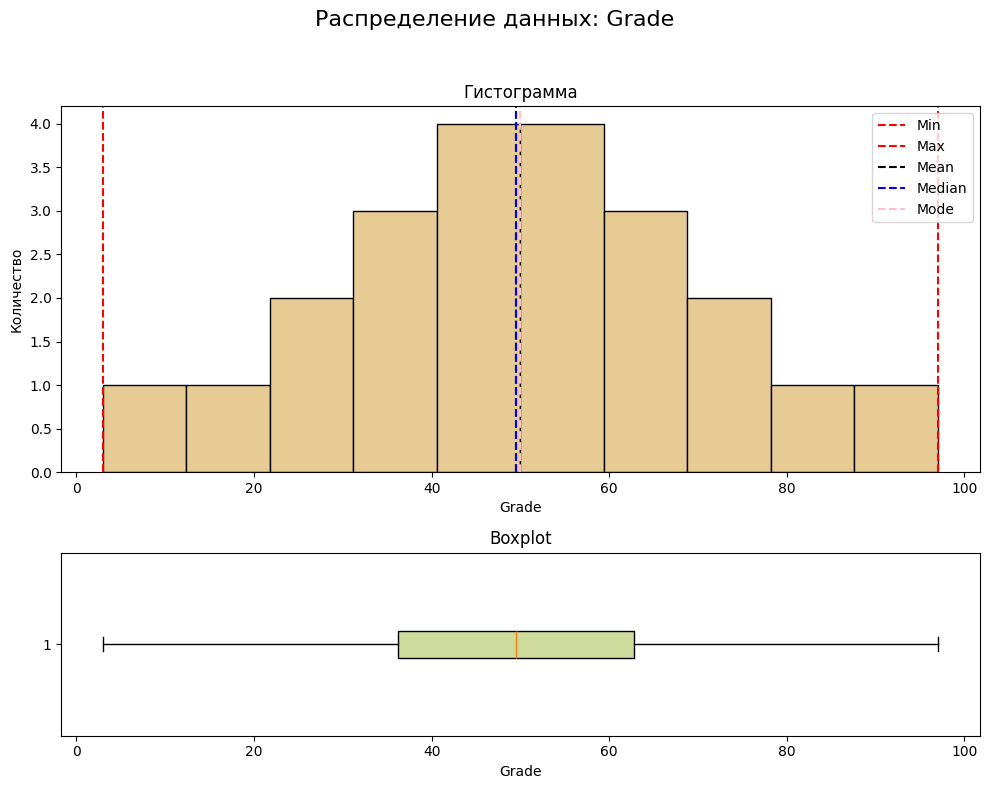

Минимум: 3.00,
Максимум: 97.00,
Среднее: 49.55,
Медиана: 49.50,
Мода: 50.00


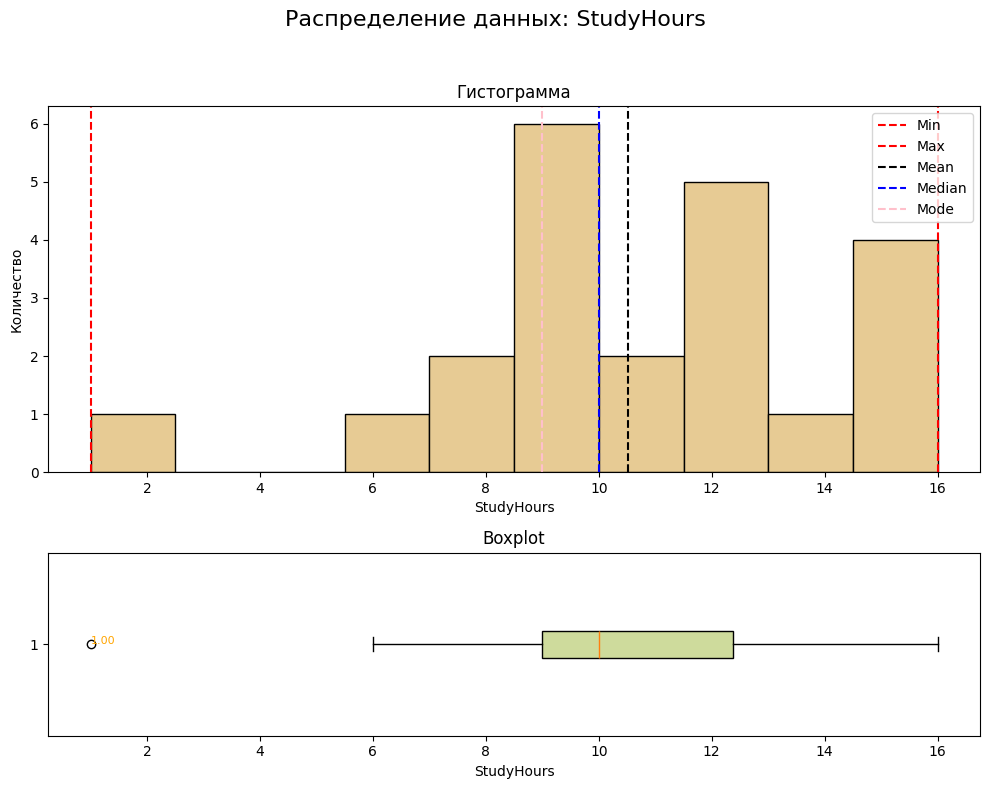

Минимум: 1.00,
Максимум: 16.00,
Среднее: 10.52,
Медиана: 10.00,
Мода: 9.00


In [2]:

# Вызов функций
# drive.mount('/content/drive') # Не удаляем строку, сохраняем на случай необходимости подключения
plot_bar_and_pie(df_students, 'Grade', 'Pass')
show_distribution(df_students['Grade'], 'Grade', enhanced=True)
show_distribution(df_students['StudyHours'], 'StudyHours', enhanced=True)


##Предобработка данных


*   Удаляем выбросы
*   Нормализуем числовые признаки



Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Коэф. корреляции = 0.92
Axes(0.125,0.11;0.775x0.77)


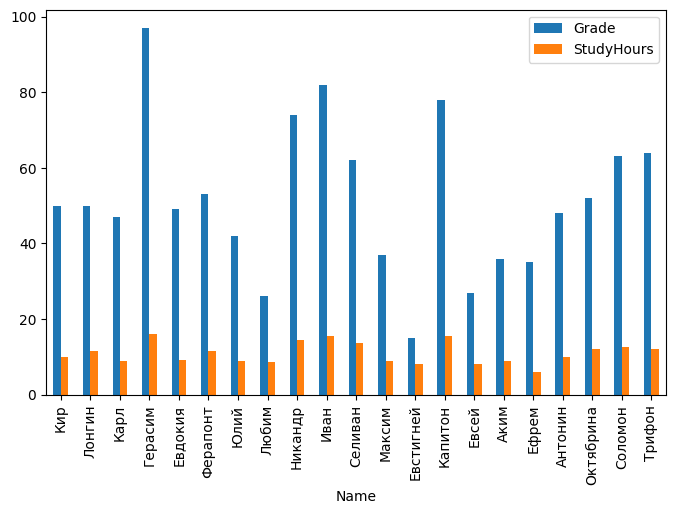

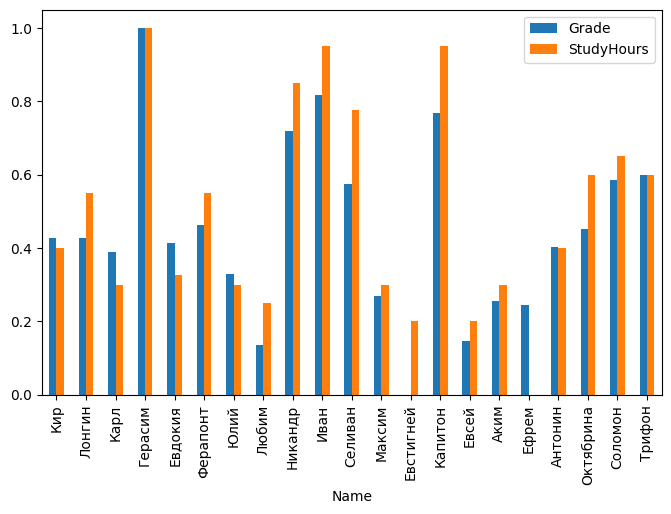

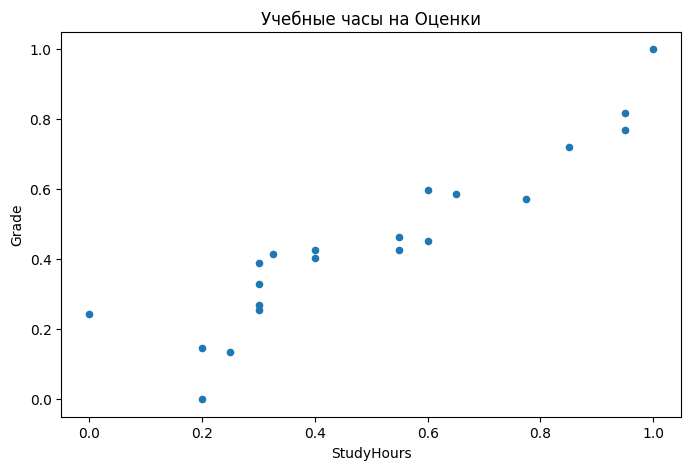

In [3]:
#Удаляю выброс в столбце StudyHours
df_cleaned = df_students[df_students.StudyHours > 1]
#Визуально оцениваю взаимную связь столбцов
print(df_cleaned.plot(x = 'Name', y = ['Grade', 'StudyHours'], kind = 'bar', figsize=(8, 5)))
#Нормализую численные значения в столбцах
df_normalized = normalize_dataframe(df_cleaned)
#Повторно визуально оцениваю взаимную связь столбцов
print(df_normalized.plot(x = 'Name', y = ['Grade', 'StudyHours'], kind = 'bar', figsize=(8, 5)))
#Численно оцениваю взаимную связь столбцов
print(f'Коэф. корреляции = {df_normalized.Grade.corr(df_normalized.StudyHours).round(2)}')
#Оцениваю разброс значений
print(df_normalized.plot.scatter(title = 'Учебные часы на Оценки',x='StudyHours', y='Grade', figsize=(8, 5)))



##Построение моделей


*   Линейная регрессия




         Name  StudyHours  Grade   Pass         fx      error
0         Кир       10.00   50.0  False  45.378494  -4.621506
1      Лонгин       11.50   50.0  False  55.187150   5.187150
2        Карл        9.00   47.0  False  38.839390  -8.160610
3     Герасим       16.00   97.0   True  84.613118 -12.386882
4     Евдокия        9.25   49.0  False  40.474166  -8.525834
6    Ферапонт       11.50   53.0  False  55.187150   2.187150
7        Юлий        9.00   42.0  False  38.839390  -3.160610
8       Любим        8.50   26.0  False  35.569838   9.569838
9     Никандр       14.50   74.0   True  74.804462   0.804462
10       Иван       15.50   82.0   True  81.343566  -0.656434
11    Селиван       13.75   62.0   True  69.900134   7.900134
12     Максим        9.00   37.0  False  38.839390   1.839390
13  Евстигней        8.00   15.0  False  32.300286  17.300286
14    Капитон       15.50   78.0   True  81.343566   3.343566
15      Евсей        8.00   27.0  False  32.300286   5.300286
16      

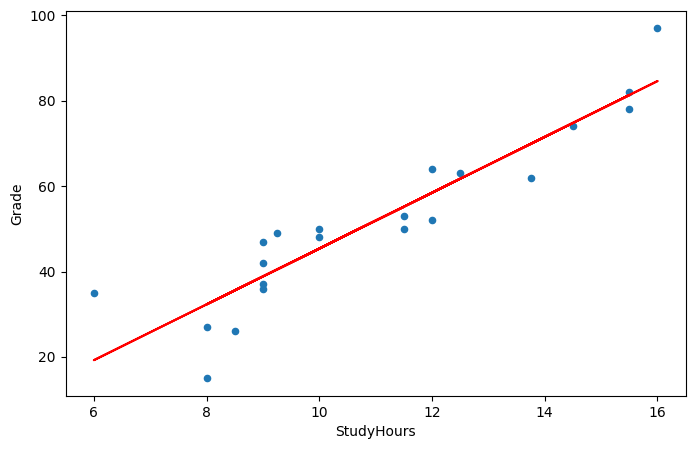

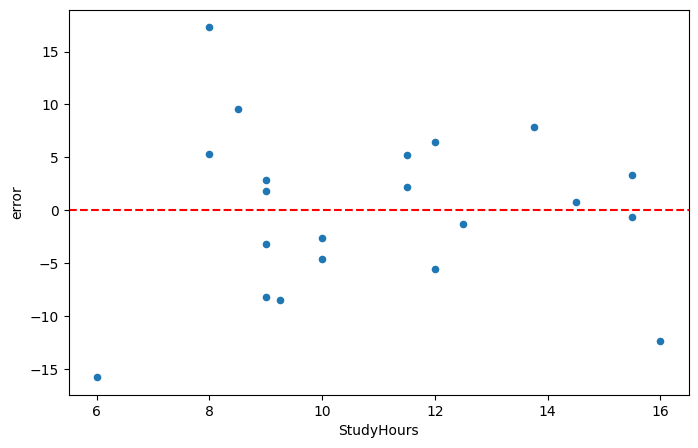

In [12]:


# Вызываем функцию Линейной Регрессии
df_modified, m, b, r, p, se = linear_regression_with_target(df_cleaned, target_column="Grade")

# Выводим модернизированный DataFrame и коэффициенты
print(df_modified)
print(f"\nm — угловой коэффициент (slope) линии: {m.round(2)}, \nb — точка пересечения с осью Y (intercept): {b.round(2)}, \nr — коэффициент корреляции: {r.round(2)}, \npc — p-значение теста значимости: {p}, \nse — стандартная ошибка оценки коэффициентов: {se.round(2)}")


df_modified.plot.scatter(x='StudyHours', y='Grade', figsize=(8, 5))
plt.plot(df_modified.StudyHours, df_modified.fx, color='red')

df_modified.plot.scatter(x='StudyHours', y='error', figsize=(8, 5))
plt.axhline(y=0, color='red', linestyle='--')

plt.show()


##Предсказамус настрадал

In [53]:
# Определяем функцию для предсказания оценки ученика
# Вводит количество учебных часов и получает предполагаемую оценку

def predict():
    # Пишем условие для выхода из бесконечного цикла
    print('Для выхода из функции - введи любое не числовое значение в поле для ввода.')
    # Запускаем бесконечный цикл, который продолжается, пока не введется некорректное значение
    while True:
        try:
            # Вводим количество учебных часов ученика
            x = int(input('\nВведите количество учебных часов ученика, затем нажмите "Enter": '))
            # Рассчитываем предполагаемую оценку по формуле
            predict = (m * x + b).round(1)
            # Если оценка меньше или равна нулю, заменяем на 1
            if predict <= 0:
                predict = 1
            # Выводим предполагаемую оценку
            print(f'Предположительная оценка ученика = {predict}')
        except ValueError:
            # Если введено некорректное значение, выходим из цикла
            print('Выход из программы')
            break

In [54]:
predict()

Для выхода из функции - введи любое не числовое значение в поле для ввода.

Введите количество учебных часов ученика, затем нажмите "Enter": 1
Предположительная оценка ученика = 1

Введите количество учебных часов ученика, затем нажмите "Enter": 2
Предположительная оценка ученика = 1

Введите количество учебных часов ученика, затем нажмите "Enter": 3
Предположительная оценка ученика = 1

Введите количество учебных часов ученика, затем нажмите "Enter": 4
Предположительная оценка ученика = 6.1

Введите количество учебных часов ученика, затем нажмите "Enter": 5
Предположительная оценка ученика = 12.7

Введите количество учебных часов ученика, затем нажмите "Enter": q
Выход из программы


##Выводы и рекомендации

Давай поэтапно разберём код функции - linear_regression_with_target.

`m, b, r, p, se = stats.linregress(df_regression.StudyHours, df_regression.Grade)`

Здесь используется функция linregress из библиотеки scipy.stats, которая выполняет линейную регрессию.

**Линейная регрессия — это метод, который пытается найти прямую (линейное уравнение), наилучшим образом описывающую зависимость между двумя переменными. В нашем случае, она будет искать зависимость между часами учёбы и оценками.**
    
    df_regression.StudyHours — это данные по часам учёбы (независимая переменная, X).
    df_regression.Grade — это данные по оценкам (зависимая переменная, Y).

Функция linregress возвращает несколько значений:

    m — угловой коэффициент (slope) линии.
    b — точка пересечения с осью Y (intercept).
    r — коэффициент корреляции.
    p — p-значение теста значимости.
    se — стандартная ошибка оценки коэффициентов.

`df_regression['fx'] = (m * df_regression.StudyHours) + b`

Здесь рассчитывается линейное уравнение, которое предсказывает оценки (Grade) на основе количества часов учёбы (StudyHours):

Для каждого значения StudyHours в df_regression рассчитывается соответствующее значение предсказанной оценки fx с использованием уравнения прямой:

`fx=m×StudyHours+bfx=m×StudyHours+b `

Где:
        m — угловой коэффициент.
        b — точка пересечения с осью Y.

Этот столбец fx в DataFrame теперь содержит предсказания оценки для каждого студента по их часам учёбы.

`df_regression['error'] = df_regression['fx'] - df_regression['Grade']`

Здесь рассчитывается ошибка для каждого наблюдения (студента). Ошибка определяется как разница между предсказанной оценкой fx и реальной оценкой Grade:

    Если ошибка близка к 0, это значит, что модель хорошо предсказывает оценки.
    Если ошибка большая, то модель даёт менее точные предсказания.

Таким образом, в столбце error будут отображаться отклонения предсказанных значений от реальных.


**Итог:**

    Копирование DataFrame:
    Мы создаём копию исходного DataFrame, чтобы не изменить оригинальные данные.

    Выбор числовых столбцов:
    Мы выбираем только числовые столбцы с помощью select_dtypes(include=['number']).

    Линейная регрессия:
    Для выполнения регрессии выбирается первый числовой столбец как независимая переменная (X), а целевой столбец — как зависимая переменная (Y).
    Мы применяем линейную регрессию с помощью stats.linregress(x, y).

    Добавление новых столбцов:
        Столбец fx — это предсказанные значения для целевого столбца с помощью линейной регрессии: fx=m×x+bfx=m×x+b.
        Столбец error — это разница между предсказанными значениями (fx) и реальными значениями целевого столбца (Grade).

    Возвращаем результат:
    Функция возвращает модернизированный DataFrame, а также коэффициенты регрессии:
        m — угловой коэффициент.
        b — точка пересечения с осью Y.
        r — коэффициент корреляции.
        p — p-значение.
        se — стандартная ошибка.